In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from omegaconf import OmegaConf
import collections

In [2]:
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
import os

In [4]:
import collections

def flatten(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [5]:
def value_rescale(x, eps=1.0e-3):
    return np.sign(x) * (np.sqrt(np.abs(x) + 1.0) - 1.0) + eps * x

In [6]:
# Good params on cart-pole from proprio
# DIR = "/home/ira/code/projects/rl_trickery/multirun/0_saved_experiments/long_ff_cart/"

# maze



# DIR = "/home/ira/code/projects/rl_trickery/runs/2020.06.18/"

DIR = "/home/ira/code/projects/rl_trickery/multirun/2020-07-14/crnn_11-55-17/"


In [7]:
DIR.strip("/")

'home/ira/code/projects/rl_trickery/multirun/2020-07-14/crnn_11-55-17'

In [8]:
# maze runs


# maze11
# random recurse depth
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-ff-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-rnn-rand-recurse/"
# DIR = "/home/ira/code/projects/rl_trickery/multirun/000_proper_experiments/maze11-crnn-rand-recurse/"



In [9]:
MultirunResult = collections.namedtuple("MultirunResult", "name, ts_train, ts_eval, overrides, configs")


def load_dir(directory):
    directory = directory.rstrip("/") + "/"
    runs = sorted(os.listdir(directory))
    runs = [run for run in runs if "." not in run]

    dfs = {}
    dfs_eval = {}
    overrides = {}
    configs = {}
    for run in runs:
        f_eval = directory + run + "/eval.csv"
        f_train = directory + run + "/train.csv"    
        f_config = directory + run + "/.hydra/config.yaml"    
        f_override = directory + run + "/.hydra/overrides.yaml"    
        dfs[run] = pd.read_csv(f_train).set_index("timestep")
        dfs_eval[run] = pd.read_csv(f_eval).set_index("timestep")
        try:
            with open(f_override) as file:
                overrides[run] = yaml.load(file, Loader=yaml.FullLoader)
        except FileNotFoundError:
            overrides[run] = {}
        try:
            configs[run] = OmegaConf.load(f_config)
        except FileNotFoundError:
            configs[run] = {}
    
    result = MultirunResult(
        name=directory.split("/")[-2],
        ts_train=dfs,
        ts_eval=dfs_eval,
        overrides=overrides,
        configs=configs
    )
    
    return result

In [11]:
mr = load_dir(DIR)

In [12]:
scores = {}
for run, ts in mr.ts_eval.items():
#     scores[run] = -dfs_eval[run]["fraction_timeouts"][-10:].mean()
    scores[run] = ts["episode_reward"][0:].mean()
scores = pd.Series(scores)
scores

crnn_0     3.212639
crnn_1     3.755534
crnn_10    3.970694
crnn_11    4.646656
crnn_12    5.851275
crnn_13    4.614637
crnn_14    4.306215
crnn_15    3.352383
crnn_16    2.900249
crnn_17    5.906902
crnn_2     3.803351
crnn_3     3.793964
crnn_4     4.531692
crnn_5     4.299714
crnn_6     5.969258
crnn_7     3.833440
crnn_8     3.756034
crnn_9     4.559523
dtype: float64

In [13]:
rows = {}
for key, arg in mr.overrides.items():
    row = {}
    if type(arg) is list:
        for s in arg:
            col, val = s.split("=")
            row[col] = val
        rows[key] = (pd.Series(row))
results = pd.DataFrame(rows)
results = results.append(scores.rename("score"))
results = results.T.sort_values("score", ascending=False)

In [14]:
configs = {}
for key, config in mr.configs.items():
    configs[key] = flatten(config)
full_results = pd.DataFrame(configs).append(scores.rename("score")).T.sort_values("score", ascending=False)

<ipython-input-4-72a859df90ce>:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if isinstance(v, collections.MutableMapping):


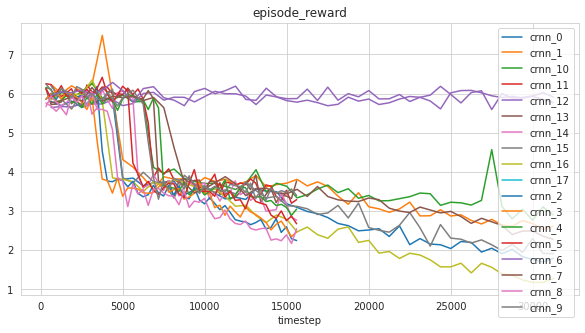

In [15]:
ax = None

target_vars = [
    "episode_reward",
    "fraction_timeouts",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in mr.ts_eval.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df[target_var]
#             df = df.rolling(0).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

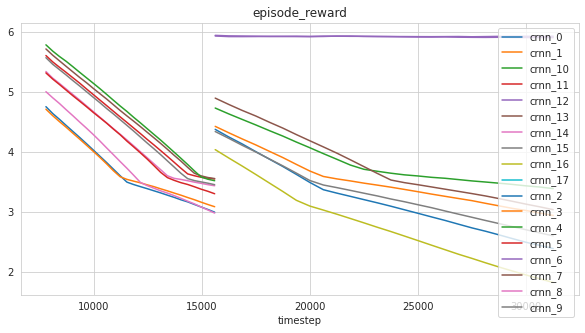

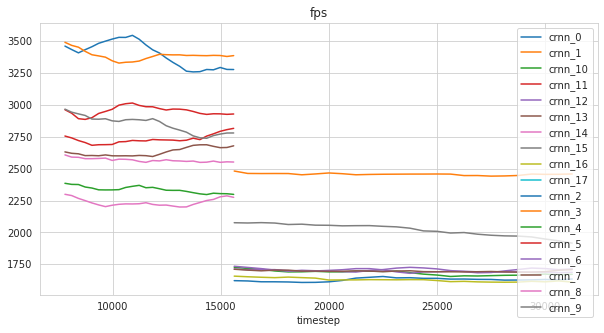

In [16]:
ax = None

target_vars = [
    "episode_reward",
    "loss_entropy",
    "act",
    "fps",
    "episode",
    "value",
]

top_q = 0.0
y_lim = None

for target_var in target_vars:
    ax = None
    for key, df in mr.ts_train.items():
        if scores[key] < scores.quantile(top_q):
            continue
        if target_var in df.columns:
            df = df[target_var]
            df = df.rolling(25).mean()
#             df = value_rescale(df)
            ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5), ylim=y_lim)
#             ax = df.reset_index().plot(x="timestep", y=target_var, label=key, ax=ax, figsize=(10,5))
            plt.title(target_var)

In [17]:
results.score = results.score.map(float)

In [18]:
results

,name,lr,batch_size,network.fixed_recursive_depth,score
crnn_6,crnn,0.001,16,8,5.969258
crnn_17,NaN,NaN,NaN,NaN,5.906902
crnn_12,crnn,0.001,16,8,5.851275
crnn_11,crnn,0.0005,32,4,4.646656
crnn_13,crnn,0.0005,32,8,4.614637
crnn_9,crnn,0.0005,32,4,4.559523
crnn_4,crnn,0.0005,32,12,4.531692
crnn_14,crnn,0.0005,32,8,4.306215
crnn_5,crnn,0.001,32,4,4.299714
crnn_10,crnn,0.001,16,8,3.970694


In [19]:
def compare_mrs(mrs, col="episode_reward", show_std=False):
    colors = sns.color_palette(n_colors=len(mrs))
    ax = None
    for mr, color in zip(mrs, colors):
        joined = pd.concat(mr.ts_train.values(), axis=1)[[col]].fillna(method="ffill")
        mean = joined.mean(axis=1).rename("mean")
        std = joined.std(axis=1).rename("std")
        ax = mean.plot(ax=ax, c=color, label=mr.name, figsize=(10,5))
        if show_std:
            ax = (mean+std).plot(ax=ax, c=color, alpha=0.5, figsize=(10,5))
            ax = (mean-std).plot(ax=ax, c=color, alpha=0.5, figsize=(10,5))
    plt.legend()
    plt.title(col)

No handles with labels found to put in legend.


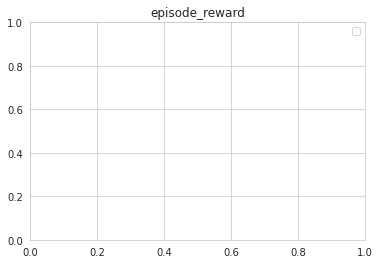

In [20]:
path = "/home/ira/code/projects/rl_trickery/multirun/0_compare/"
dirs = os.listdir(path)
mrs = [load_dir(path+dir_) for dir_ in dirs]
compare_mrs(mrs, col="episode_reward")

No handles with labels found to put in legend.


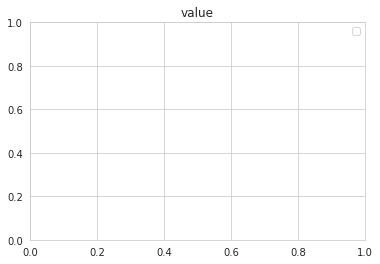

In [21]:
compare_mrs(mrs, col="value")

No handles with labels found to put in legend.


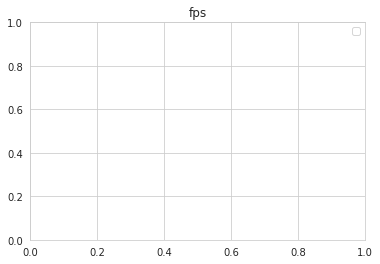

In [22]:
compare_mrs(mrs, col="fps")